## Description

This is the fifth and last notebook documenting a pipelined approach to out-of-core computation using Dask and a Stochastic Gradient Descent classifier available in Scikit-learn. Specifically, it shows how to read in multiple datasets as a single Dask dataframe as well as how to read in a single, potentially too-large-to-fit-into-memory, dataset partitioned for in-memory consumption. Furthermore, this notebook documents an *online_learning()* function that will read the dataset partitions into memory, train the model, and repeat until all partitions have been consumed. Two additional features are included in the function: data standardization and incremental PCA. Also, a print out is included after each epoch to show the average loss as well as the log loss associated with the test set. The latter is purely for example purposes. 

## Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import log_loss
import dask
import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt

## Versions

In [2]:
items = [("Dask", dask), ("Matplotlib", matplotlib), ("Numpy", np), ("Pandas", pd), ("Sklearn", sklearn)]
for item in items:
    print(item[0] + " version: " + str(item[1].__version__))

Dask version: 0.14.3
Matplotlib version: 2.0.2
Numpy version: 1.13.0
Pandas version: 0.20.1
Sklearn version: 0.18.1


## Get Data

#### Test Set

In [3]:
path = '/Users/davidziganto/data/'

X_test = pd.read_hdf(path + 'raw_HIGGS_test_data.h5', key='/a')
y_test = X_test.pop('label')

#### Training Set w/Dask
You can either read in multiple files or read in a single large file. Both implementations are included below. A wild card is used to read in multiple files. Also, please note that reading in multiple files has been commented out for the time being. 

In [4]:
# Multiple HDF5 files
#dask_df = dd.read_hdf(path + 'for_iterating/*.h5', key='/*')

# Single large HDF5 file
dask_df = dd.read_hdf(path + 'raw_HIGGS_training_data.h5', key='/a')

In [5]:
dask_df.info(memory_usage=True)

<class 'dask.dataframe.core.DataFrame'>
Columns: 29 entries, lepton_pT to label
dtypes: float64(29)
memory usage: 2.0 GB


## Online Learning

#### Mini-Batch (by partition)
Assumes your dataframe has the target variable labeled as **label**. Either change your variable name or update the code below accordingly if your target variable is named something else.

In [6]:
def online_learning(df, num_classes, model='lr', std_scale=0, pca=0):
    '''
    Inputs:
        df: dask dataframe of data
        num_classes: int denoting total number of classes present in target variable
        model: string denoting which model to use, 'lr' for logistic regression or 'nb' for naive bayes
        std_scale: flag variable (0,1) allowing user to turn on/off StandardScaler
        pca: flag variable (0,1) allowing user to turn on/off Incremental PCA
    Output:
        logloss: list of logloss values for each iteration
    '''
    # Instantiate Models
    if model == 'nb':
        model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
    elif model == 'lr':
        model = SGDClassifier(loss='log', 
                              penalty='elasticnet', 
                              alpha=0.01, 
                              l1_ratio=0.5,
                              fit_intercept=True, 
                              n_iter=1, 
                              shuffle=True, 
                              verbose=1, 
                              epsilon=None,
                              n_jobs=-1, 
                              random_state=123,
                              learning_rate='optimal',
                              eta0=0.0, 
                              power_t=0.5,
                              class_weight=None,
                              warm_start=False, 
                              average=True)
    else:
        raise Exception('Choose either "lr" or "nb" for model')
        
    # Setup
    logloss = []
    ss = StandardScaler()
    ipca = IncrementalPCA(n_components=5, whiten=True, copy=True, batch_size=None)
    counter, max_k = 0, df.npartitions-1  ## for progress updates (partition numbers)
    for i in range(df.npartitions):
        X_train = df.get_partition(i).loc[:, df.get_partition(i).columns != 'label']
        y_train = df.get_partition(i).loc[:, 'label']
        # no std_scale and no PCA
        if std_scale==0 and pca==0:
            model.partial_fit(X_train, y_train, classes=range(num_classes))
            proba = model.predict_proba(X_test)
            logloss.append(log_loss(y_test, proba))
            print('Test log loss: %.4f' % log_loss(y_test, proba))
            print('Partition {0}/{1}\n'.format(counter, max_k))
        # std_scale only
        elif std_scale and pca==0:
            ss.partial_fit(X_train)
            model.partial_fit(ss.transform(X_train), y_train, classes=range(num_classes))
            proba = model.predict_proba(ss.transform(X_test))
            logloss.append(log_loss(y_test, proba))
            print('Test log loss: %.4f' % log_loss(y_test, proba))
            print('Partition {0}/{1}\n'.format(counter, max_k))
        # throw error if PCA w/out std_scale
        elif std_scale==0 and pca:
            raise Exception('You have to set std_scale=1 for PCA to work')
        # std_scale and PCA
        else: 
            ss.partial_fit(X_train)
            ipca.partial_fit(ss.transform(X_train))
            model.partial_fit(ipca.transform(X_train), y_train, classes=range(num_classes))
            proba = model.predict_proba(ipca.transform(ss.transform(X_test)))
            logloss.append(log_loss(y_test, proba))
            print('Test log loss: %.4f' % log_loss(y_test, proba))
            print('Partition {0}/{1}\n'.format(counter, max_k))
        counter += 1
    return logloss

#### Logistic Regression

In [7]:
# this baseline online logistic regression model uses the partial_fit method but no data standardization or PCA
%time baseline = online_learning(dask_df, num_classes=2, model='lr', std_scale=0, pca=0)

-- Epoch 1
Norm: 1.98, NNZs: 14, Bias: 0.864589, T: 1000000, Avg. loss: 0.658910
Total training time: 0.50 seconds.
Test log loss: 1.5361
Partition 0/8

-- Epoch 1
Norm: 1.53, NNZs: 13, Bias: 0.336160, T: 1000000, Avg. loss: 0.656803
Total training time: 0.50 seconds.
Test log loss: 1.0435
Partition 1/8

-- Epoch 1
Norm: 1.39, NNZs: 13, Bias: 0.208616, T: 1000000, Avg. loss: 0.656717
Total training time: 0.53 seconds.
Test log loss: 0.8831
Partition 2/8

-- Epoch 1
Norm: 1.31, NNZs: 13, Bias: 0.146599, T: 1000000, Avg. loss: 0.656523
Total training time: 0.47 seconds.
Test log loss: 0.8089
Partition 3/8

-- Epoch 1
Norm: 1.26, NNZs: 13, Bias: 0.113893, T: 1000000, Avg. loss: 0.656801
Total training time: 0.54 seconds.
Test log loss: 0.7680
Partition 4/8

-- Epoch 1
Norm: 1.22, NNZs: 13, Bias: 0.091540, T: 1000000, Avg. loss: 0.656381
Total training time: 0.54 seconds.
Test log loss: 0.7426
Partition 5/8

-- Epoch 1
Norm: 1.20, NNZs: 13, Bias: 0.078037, T: 1000000, Avg. loss: 0.656267
T

In [8]:
# this online logistic regression model uses the partial_fit method and data standardization but no PCA
%time std = online_learning(dask_df, num_classes=2, std_scale=1, pca=0)

-- Epoch 1
Norm: 1.91, NNZs: 15, Bias: 0.115434, T: 1000000, Avg. loss: 0.644589
Total training time: 0.56 seconds.
Test log loss: 1.7554
Partition 0/8

-- Epoch 1
Norm: 1.43, NNZs: 16, Bias: 0.118859, T: 1000000, Avg. loss: 0.642544
Total training time: 0.52 seconds.
Test log loss: 1.1402
Partition 1/8

-- Epoch 1
Norm: 1.27, NNZs: 16, Bias: 0.123690, T: 1000000, Avg. loss: 0.642815
Total training time: 0.46 seconds.
Test log loss: 0.9366
Partition 2/8

-- Epoch 1
Norm: 1.18, NNZs: 16, Bias: 0.119004, T: 1000000, Avg. loss: 0.642687
Total training time: 0.53 seconds.
Test log loss: 0.8406
Partition 3/8

-- Epoch 1
Norm: 1.12, NNZs: 16, Bias: 0.119333, T: 1000000, Avg. loss: 0.643305
Total training time: 0.56 seconds.
Test log loss: 0.7870
Partition 4/8

-- Epoch 1
Norm: 1.09, NNZs: 16, Bias: 0.119163, T: 1000000, Avg. loss: 0.642879
Total training time: 0.50 seconds.
Test log loss: 0.7537
Partition 5/8

-- Epoch 1
Norm: 1.06, NNZs: 16, Bias: 0.119163, T: 1000000, Avg. loss: 0.642784
T

In [9]:
# this online logistic regression model uses the partial_fit method, data standardization, 
# and PCA w/whitening (number of components set to 5 but can change in function above)
%time pca = online_learning(dask_df, num_classes=2, model='lr', std_scale=1, pca=1)

-- Epoch 1
Norm: 0.59, NNZs: 3, Bias: 0.305601, T: 1000000, Avg. loss: 0.688785
Total training time: 0.26 seconds.
Test log loss: 1.1795
Partition 0/8

-- Epoch 1
Norm: 0.33, NNZs: 3, Bias: 0.214919, T: 1000000, Avg. loss: 0.689126
Total training time: 0.26 seconds.
Test log loss: 0.8899
Partition 1/8

-- Epoch 1
Norm: 0.25, NNZs: 3, Bias: 0.160438, T: 1000000, Avg. loss: 0.689267
Total training time: 0.27 seconds.
Test log loss: 0.8045
Partition 2/8

-- Epoch 1
Norm: 0.22, NNZs: 3, Bias: 0.120128, T: 1000000, Avg. loss: 0.689477
Total training time: 0.27 seconds.
Test log loss: 0.7672
Partition 3/8

-- Epoch 1
Norm: 0.21, NNZs: 2, Bias: 0.118554, T: 1000000, Avg. loss: 0.689587
Total training time: 0.28 seconds.
Test log loss: 0.7462
Partition 4/8

-- Epoch 1
Norm: 0.20, NNZs: 2, Bias: 0.117552, T: 1000000, Avg. loss: 0.689502
Total training time: 0.27 seconds.
Test log loss: 0.7330
Partition 5/8

-- Epoch 1
Norm: 0.18, NNZs: 2, Bias: 0.117196, T: 1000000, Avg. loss: 0.689593
Total tr

#### Naive Bayes

In [10]:
# this model is an example of an online naive bayes model without data standardization or PCA
%time nb_ = online_learning(dask_df, num_classes=2, model='nb', std_scale=0, pca=0)

Test log loss: 0.6895
Partition 0/8

Test log loss: 0.6895
Partition 1/8

Test log loss: 0.6895
Partition 2/8

Test log loss: 0.6895
Partition 3/8

Test log loss: 0.6895
Partition 4/8

Test log loss: 0.6895
Partition 5/8

Test log loss: 0.6895
Partition 6/8

Test log loss: 0.6895
Partition 7/8

Test log loss: 0.6895
Partition 8/8

CPU times: user 44.8 s, sys: 17.1 s, total: 1min 1s
Wall time: 58.1 s


You may be wondering why the **Test log loss** value doesn't seem to change. It does. The reason it doesn't appear to change has to do with rounding. I specifically set the print out to only show the first four decimal places. Go ahead and change this value to see the very tiny changes that occur by iteration.

## Plot Log Loss on Test Set
The **plot_function()** below is used to compare log loss on the test set for the different approaches: baseline, with data standardization, and with PCA.

In [11]:
def plot_function(log_loss_dict, path=None):
    '''
    Input:
        log_loss_dict: a dictionary where the key is a name and the values are log loss values by iteration
        path: string with path to where plot should be saved
    Output:
        plot with labeled axes and title showing difference between baseline, StandardScaler, and PCA approaches
    '''
    colors = ('darkred', 'darkblue', 'darkgreen', 'darkorange')
    num_keys = len(log_loss_dict.keys())
    counter, legend = 0, []
    for k,v in log_loss_dict.items():
        plt.plot(range(len(v)), v, '.-', color=colors[counter])
        counter +=1
        legend.append(k)
    plt.xlabel('iteration #')
    plt.ylabel('log loss value (test set)')
    plt.title('log loss vs iteration #')
    plt.legend(legend)
    plt.grid()
    if path is not None:
        plt.savefig(path)

In [12]:
# create dictionary of different cases: baseline, data standardization, PCA, and Naive Bayes
log_loss_dict = {'baseline lr':baseline, 'std lr':std, 'pca lr':pca, 'naive bayes':nb_}

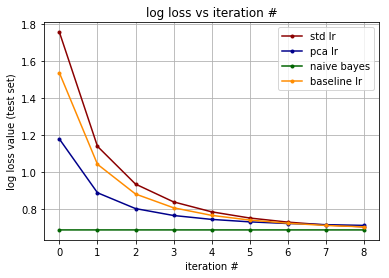

In [13]:
# create plot and save
mypath = '/Users/davidziganto/Repositories/Out-of-Core-Computation/images/comparison.png'
plot_function(log_loss_dict, path=mypath)